# Data Preprocessing

## Library

In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

## Loading Data

In [3]:
df = pd.read_csv("cybersecurity_attacks.csv")  
print(df.head())
print(df.shape)

             Timestamp Source IP Address Destination IP Address  Source Port  \
0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
4  2023-07-16 13:11:07     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2             53600      UDP            306     Control         HTTP   
3             32534      UDP            385        Data         HTTP   
4             26646      TCP           1462        Data          DNS   

                                        Payload Data  ... Action Taken  \
0  Qui natus

## Missing Values

In [4]:
missing_values = df.isnull().values.any()
n_missing = df.isnull().sum()
print("Are there any missing values: ", missing_values)
print(n_missing)

#After further inspecting the data, we have come on to the following 
#conclusion to result with the missing data


#replace Malware Indicators null with "non detected"
df['Malware Indicators'] = df['Malware Indicators'].fillna("Non Detected")
#replace Alerts/Warnings  null with "No Alert triggered"
df['Alerts/Warnings'] = df['Alerts/Warnings'].fillna("No Alert Triggered")
#replace Proxy Information, Firewall Logs, and IDS/IPS Alerts null values with "Missing"
df['Proxy Information'] = df['Proxy Information'].fillna("Missing")
df['Firewall Logs'] = df['Firewall Logs'].fillna("Missing")
df['IDS/IPS Alerts'] = df['IDS/IPS Alerts'].fillna("Missing")
missing_values = df.isnull().values.any()
print("Are there any missing values: ", missing_values)

Are there any missing values:  True
Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators        20000
Anomaly Scores                0
Alerts/Warnings           20067
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64
Are there any missing values:  False


In [5]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print('-' * 50)

Column: Timestamp
['2023-05-30 06:33:58' '2020-08-26 07:08:30' '2022-11-13 08:23:25' ...
 '2022-03-31 01:45:49' '2023-09-22 18:32:38' '2023-10-10 11:59:52']
--------------------------------------------------
Column: Source IP Address
['103.216.15.12' '78.199.217.198' '63.79.210.48' ... '162.35.217.57'
 '208.72.233.205' '14.102.21.108']
--------------------------------------------------
Column: Destination IP Address
['84.9.164.252' '66.191.137.154' '198.219.82.17' ... '98.107.0.15'
 '173.79.112.252' '109.198.45.7']
--------------------------------------------------
Column: Protocol
['ICMP' 'UDP' 'TCP']
--------------------------------------------------
Column: Packet Type
['Data' 'Control']
--------------------------------------------------
Column: Traffic Type
['HTTP' 'DNS' 'FTP']
--------------------------------------------------
Column: Payload Data
['Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\r\nMaiores possimus ipsum 

Dropping data that can not be encoded easily, like Timestamp and other features with more than 5 options

In [6]:
df_encoded = df.drop([
    'Timestamp',
    'Source IP Address',
    'Destination IP Address',
    'Payload Data',
    'Device Information',
    'Proxy Information',
    'User Information',
    'Geo-location Data'
], axis=1)

selected_columns = ['Protocol','Log Source','IDS/IPS Alerts','Network Segment','Severity Level',
                    'Action Taken','Malware Indicators','Alerts/Warnings','Attack Type','Attack Signature'
                   , 'Protocol','Packet Type','Traffic Type','Firewall Logs']
ordinal_encoder = OrdinalEncoder()
df_encoded[selected_columns] = ordinal_encoder.fit_transform(df_encoded[selected_columns])
corr_matrix = df_encoded.corr()


Checking if there any strong correlation between variables that needs to be dropped

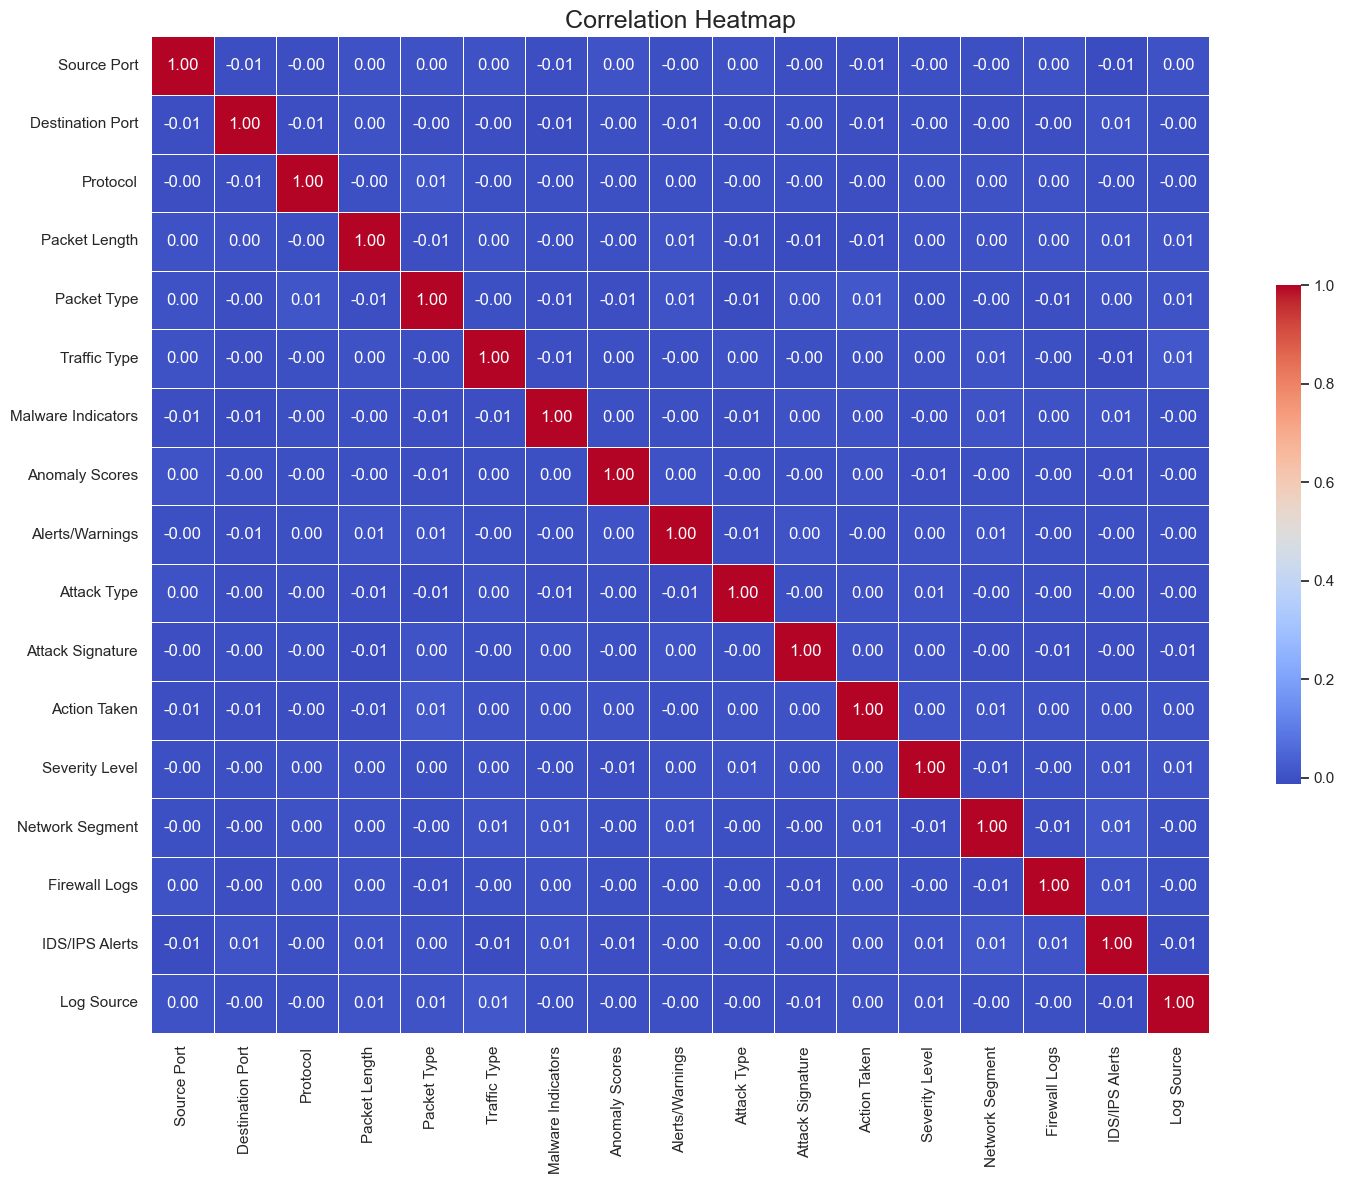

In [7]:
# Set figure size and style
plt.figure(figsize=(15, 12))
sns.set(style="white")

# Plot the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,       # show correlation values
    fmt=".2f",        # format as 2 decimal places
    cmap='coolwarm',  # color palette
    linewidths=0.5,   # lines between squares
    cbar_kws={'shrink': .5}  # smaller color bar
)

plt.title('Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

MinMaxScaler used for Port source and Destination Port as there is a fixed range

Standard Scaler is used as it may better deal with heavily skewed and varied data like Packet Length

In [8]:
scalerMinMax = MinMaxScaler()


df_encoded['Source Port'] = scalerMinMax.fit_transform(df_encoded[['Source Port']])
df_encoded['Destination Port'] = scalerMinMax.fit_transform(df_encoded[[ 'Destination Port']])

scalerStand = StandardScaler()

df_encoded['Packet Length'] = scalerStand.fit_transform(df_encoded[['Packet Length']])

Quick random forrest trea to see which features are weak


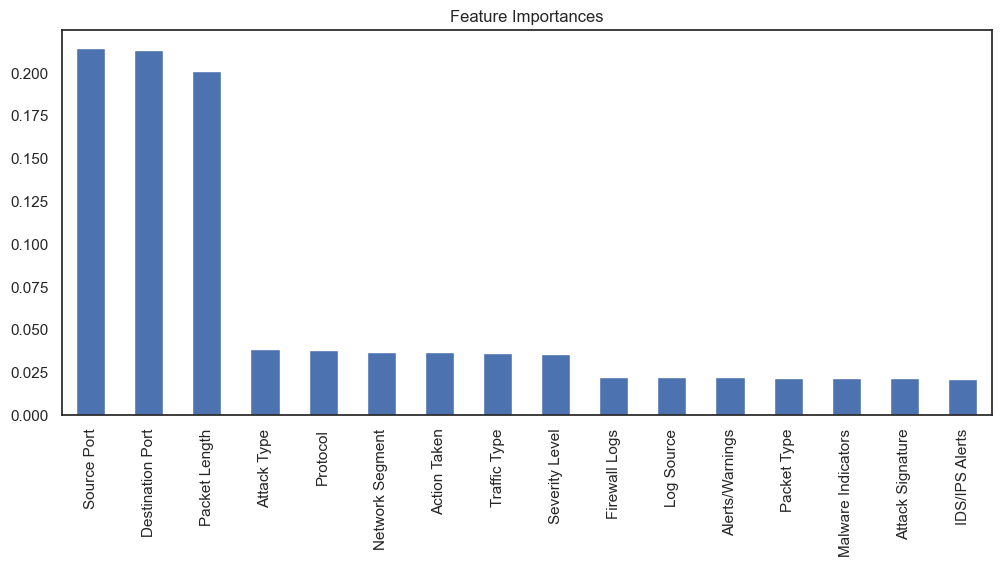

In [9]:

target = 'Anomaly Scores'
y = df_encoded[target]

X = df_encoded.drop(columns=[target])


rf = RandomForestRegressor()
rf.fit(X.fillna(0), y)  # fillna is just to make sure
#num_minmax = ['Source Port', 'Destination Port']
#num_standard = ['Packet Length']
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.title("Feature Importances")
plt.show()

# Applying PCA

### Note to teammates
Please feel free to test around and potentially dropping some of the lower features, that is the preprocessing done, next the PCA needs to be applied

In [10]:
print(X.head())
print(y.head())

   Source Port  Destination Port  Protocol  Packet Length  Packet Type  \
0     0.468164          0.257196       0.0      -0.669295          1.0   
1     0.251430          0.730759       0.0       0.943535          1.0   
2     0.244702          0.814993       2.0      -1.142808          0.0   
3     0.294420          0.488444       2.0      -0.952922          1.0   
4     0.079128          0.397173       1.0       1.635778          1.0   

   Traffic Type  Malware Indicators  Alerts/Warnings  Attack Type  \
0           2.0                 0.0              1.0          2.0   
1           2.0                 0.0              1.0          2.0   
2           2.0                 0.0              0.0          0.0   
3           2.0                 1.0              0.0          2.0   
4           0.0                 1.0              0.0          0.0   

   Attack Signature  Action Taken  Severity Level  Network Segment  \
0               1.0           2.0             1.0              0.0   


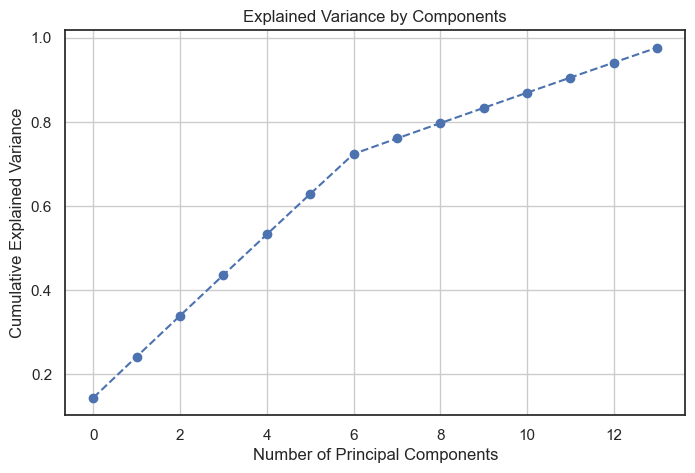

Number of components selected: 14


In [12]:
pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X)

# Explained variance plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid()
plt.show()

# Number of selected components
print(f"Number of components selected: {pca.n_components_}")